# Import Packages

In [1]:
import pandas as pd
import matplotlib.pyplot as plt
%matplotlib inline
import seaborn as sns
import numpy as np
from sklearn.preprocessing import StandardScaler

# Import Classifiers & Packages for Modeling

In [2]:
from sklearn.model_selection import train_test_split, GridSearchCV
from sklearn.metrics import classification_report, confusion_matrix , accuracy_score, f1_score
from sklearn.model_selection import cross_val_score

from sklearn.dummy import DummyClassifier
from sklearn.neighbors import KNeighborsClassifier
from sklearn.tree import DecisionTreeClassifier
from sklearn.ensemble import BaggingClassifier, RandomForestClassifier, AdaBoostClassifier, GradientBoostingClassifier
from sklearn.svm import SVC
from xgboost import XGBClassifier

from IPython.display import Image  
from sklearn.tree import export_graphviz
from pydotplus import graph_from_dot_data

# Load Data

In [3]:
ipeds_data = pd.read_csv('ipeds_new_data.csv')
ipeds_data.drop('Unnamed: 0', axis = 1, inplace = True)
ipeds_data.head()

,unitid,inst_name,state_abbr,region,urban_centric_locale,title_iv_indicator,inst_control,institution_level,inst_category,inst_size,...,cb_region,headcount_asn_Total_prop,headcount_blk_Total_prop,headcount_hsp_Total_prop,headcount_hwnpi_Total_prop,headcount_mlt_Total_prop,headcount_nonres_Total_prop,headcount_ntv_Total_prop,headcount_unknown_Total_prop,headcount_wht_Total_prop
0,102553.0,University of Alaska Anchorage,AK,8.0,11.0,1.0,1.0,4.0,2.0,4.0,...,West,0.060485,0.030683,0.070895,0.006632,0.086845,0.015237,0.064473,0.072448,0.592302
1,102614.0,University of Alaska Fairbanks,AK,8.0,23.0,1.0,1.0,4.0,2.0,3.0,...,West,0.018203,0.022080,0.054947,0.008680,0.052419,0.011377,0.200067,0.181864,0.450362
2,102632.0,University of Alaska Southeast,AK,8.0,33.0,1.0,1.0,4.0,2.0,2.0,...,West,0.035880,0.011100,0.055756,0.007486,0.070986,0.009293,0.119773,0.156686,0.533041
3,102845.0,Charter College,WA,8.0,12.0,1.0,3.0,4.0,3.0,2.0,...,West,0.002653,0.062776,0.269231,0.055040,0.049735,0.000000,0.101459,0.055261,0.403846
4,103945.0,CollegeAmerica-Flagstaff,AZ,6.0,13.0,1.0,2.0,4.0,3.0,1.0,...,West,0.000000,0.022059,0.058824,0.007353,0.132353,0.000000,0.558824,0.000000,0.220588


In [4]:
ipeds_data.columns.values

array(['unitid', 'inst_name', 'state_abbr', 'region',
       'urban_centric_locale', 'title_iv_indicator', 'inst_control',
       'institution_level', 'inst_category', 'inst_size', 'sector',
       'hbcu', 'hospital', 'medical_degree', 'tribal_college',
       'land_grant', 'offering_highest_degree', 'offering_highest_level',
       'offering_grad', 'cc_basic_2015', 'cc_instruc_undergrad_2015',
       'cc_enroll_2015', 'cc_size_setting_2015', 'inst_affiliation',
       'occupational_prog_offered', 'academic_prog_offered',
       'avocational_prog_offered', 'remedial_prog_offered',
       'secondary_prog_offered', 'assoc_offered', 'bach_offered',
       'postbac_cert_offered', 'masters_offered',
       'doctors_research_offered', 'doctors_professional_offered',
       'doctors_other_offered', 'remedial_services',
       'academic_counseling', 'employment_services', 'placement_services',
       'oncampus_daycare', 'oncampus_housing', 'oncampus_required',
       'meal_plan', 'tuition_vari

# Make Dummy Variables

In [5]:
dummy_vars = ['institution_level', 'inst_control', 'inst_category', 'inst_size', 
              'tuition_varies', 'study_abroad', 'yellow_ribbon_program', 
              'weekend_evening_college', 'oncampus_housing', 'rotc']
# added more contiuous variables about race proportions
cont_vars = ['headcount_blk_Total_prop', 'headcount_hsp_Total_prop', 
             'headcount_wht_Total_prop', 'headcount_hwnpi_Total_prop', 
             'headcount_ntv_Total_prop', 'headcount_asn_Total_prop', 
             'lowincome_pct', 'fafsa_sent_2ormore_pct', 
             'independent_pct', 'first_gen_student_pct', 'faminc_mean']

In [6]:
dummies = ipeds_data[dummy_vars].astype('str')
cont = ipeds_data[cont_vars]
X = pd.get_dummies(pd.concat([dummies, cont], axis = 1), drop_first = True)
y = ipeds_data['cb_region']

# Train, Test, Split

In [7]:
X_train, X_test, y_train, y_test = train_test_split(X, y, test_size = 0.3, random_state = 42) 

# UNSCALED MODELS

# Baseline Model: Dummy Classifier (F1 = 0.45)

In [8]:
dummy_clf = DummyClassifier(strategy = 'stratified', random_state = 42)
dummy_clf.fit(X_train, y_train)
dummy_y_pred = dummy_clf.predict(X_test)
print(classification_report(y_test, dummy_y_pred))

              precision    recall  f1-score   support

   Northeast       0.47      0.47      0.47       174
        West       0.44      0.44      0.44       165

    accuracy                           0.45       339
   macro avg       0.45      0.45      0.45       339
weighted avg       0.45      0.45      0.45       339



# K-Nearest Neighbors (n = 1) (F1 = 0.58)

In [9]:
scaler = StandardScaler()  
scaler.fit(X_train)

X_train_scale = scaler.transform(X_train)  
X_test_scale = scaler.transform(X_test)  

model = KNeighborsClassifier(n_neighbors=1)
model.fit(X_train_scale, y_train)

knn_y_pred = model.predict(X_test_scale)

In [10]:
# F1 = 2 * (precision * recall) / (precision + recall)

f1_score(y_test, knn_y_pred, average='weighted')

0.7846982482258335

In [11]:
cm = confusion_matrix(y_test, knn_y_pred)
regions = ['Northeast', 'West']

In [12]:
def plot_confusion_matrix(cm, classes,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues):
    """
    This function prints and plots the confusion matrix.
    Normalization can be applied by setting `normalize=True`.
    """
    if normalize:
        cm = cm.astype('float') / cm.sum(axis=1)[:, np.newaxis]
        print("Normalized confusion matrix")
    else:
        print('Confusion Matrix, without normalization')

    print(cm)

    plt.imshow(cm, interpolation='nearest', cmap=cmap)
    plt.title(title)
    plt.colorbar()
    tick_marks = np.arange(len(classes))
    plt.xticks(tick_marks, classes, rotation=45)
    plt.yticks(tick_marks, classes)

    fmt = '.2f' if normalize else 'd'
    thresh = cm.max() / 1.21
    for i, j in itertools.product(range(cm.shape[0]), range(cm.shape[1])):
        plt.text(j, i, format(cm[i, j], fmt),
                 horizontalalignment="center",
                 color = "white" if cm[i, j] > thresh else "black")

    plt.tight_layout()
    plt.ylabel('True label')
    plt.xlabel('Predicted label')

Confusion Matrix, without normalization
[[135  39]
 [ 34 131]]


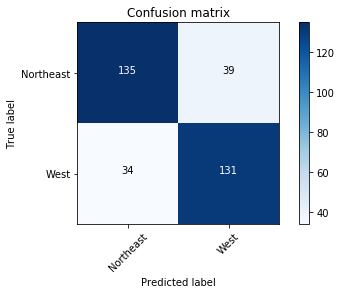

In [13]:
import itertools
plot_confusion_matrix(cm, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [14]:
print(classification_report(y_test, knn_y_pred))

              precision    recall  f1-score   support

   Northeast       0.80      0.78      0.79       174
        West       0.77      0.79      0.78       165

    accuracy                           0.78       339
   macro avg       0.78      0.78      0.78       339
weighted avg       0.79      0.78      0.78       339



In [15]:
# Accuracy of training and test sets
test_accuracy = accuracy_score(y_test, knn_y_pred)

print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Validation accuracy: 78.47%


## Optimize k for KNN

In [16]:
# search for an optimal value of K for KNN
k_range = list(range(1, 25))
k_scores = []
for k in k_range:
    knn = KNeighborsClassifier(n_neighbors=k)
    knn.fit(X_train_scale, y_train)
    y_predict = knn.predict(X_test_scale)
    score = f1_score(y_test, y_predict, average='weighted')
    k_scores.append( score)
pd.DataFrame(list(zip(k_range, k_scores)), columns = ['k', 'scores']).sort_values(by = 'scores', 
                                                                                  ascending = False).head()

,k,scores
2,3,0.802394
4,5,0.787648
0,1,0.784698
1,2,0.775083
5,6,0.774671


## K-Nearest Neighbors (k = 3) (F1 = 0.78)

In [17]:
knn_opt = KNeighborsClassifier(n_neighbors=3)
knn_opt.fit(X_train_scale, y_train)

knn_opt_y_pred = model.predict(X_test_scale)

In [18]:
f1_score(y_test, knn_opt_y_pred, average='weighted')

0.7846982482258335

Confusion Matrix, without normalization
[[135  39]
 [ 34 131]]


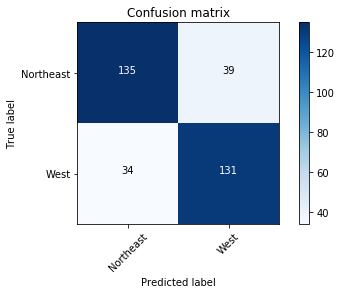

In [20]:
cm8 = confusion_matrix(y_test, knn_opt_y_pred)
plot_confusion_matrix(cm8, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [21]:
print(classification_report(y_test, knn_opt_y_pred))

              precision    recall  f1-score   support

   Northeast       0.80      0.78      0.79       174
        West       0.77      0.79      0.78       165

    accuracy                           0.78       339
   macro avg       0.78      0.78      0.78       339
weighted avg       0.79      0.78      0.78       339



In [22]:
# Accuracy of training and test sets
test_accuracy = accuracy_score(y_test, knn_opt_y_pred)

print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Validation accuracy: 78.47%


# Decision Tree (max_depth = 2) (F1 = 0.78)

In [267]:
from sklearn.tree import DecisionTreeClassifier
dtree=DecisionTreeClassifier(max_depth = 2, random_state = 42)
dtree.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=2,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [268]:
dtree_y_pred = dtree.predict(X_test)

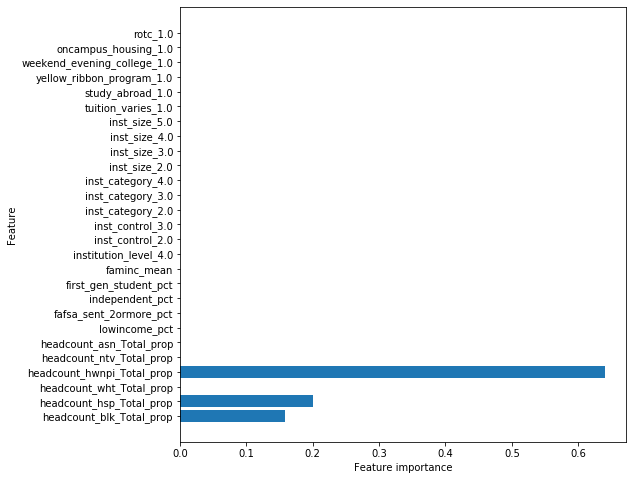

In [269]:
import numpy as np
def plot_feature_importances(model):
    n_features = X_train.shape[1]
    plt.figure(figsize=(8,8))
    plt.barh(range(n_features), model.feature_importances_, align='center') 
    plt.yticks(np.arange(n_features), X_train.columns.values) 
    plt.xlabel('Feature importance')
    plt.ylabel('Feature')

plot_feature_importances(dtree.fit(X_train, y_train))

In [270]:
print(accuracy_score(y_test, dtree_y_pred))
print(f1_score(y_test, dtree_y_pred, average='weighted'))

0.7817109144542773
0.7811668657364677


Confusion Matrix, without normalization
[[126  48]
 [ 26 139]]


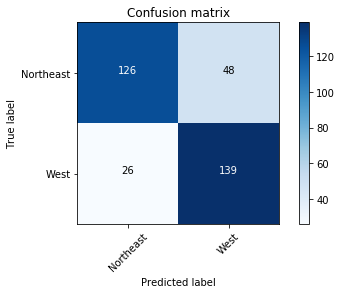

In [271]:
cm_tree = confusion_matrix(y_test, dtree_y_pred)
plot_confusion_matrix(cm_tree, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [272]:
print(classification_report(y_test, dtree_y_pred))

              precision    recall  f1-score   support

   Northeast       0.83      0.72      0.77       174
        West       0.74      0.84      0.79       165

    accuracy                           0.78       339
   macro avg       0.79      0.78      0.78       339
weighted avg       0.79      0.78      0.78       339



In [329]:
# Accuracy of training and test sets
test_accuracy = accuracy_score(y_test, dtree_y_pred)

print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Validation accuracy: 78.17%


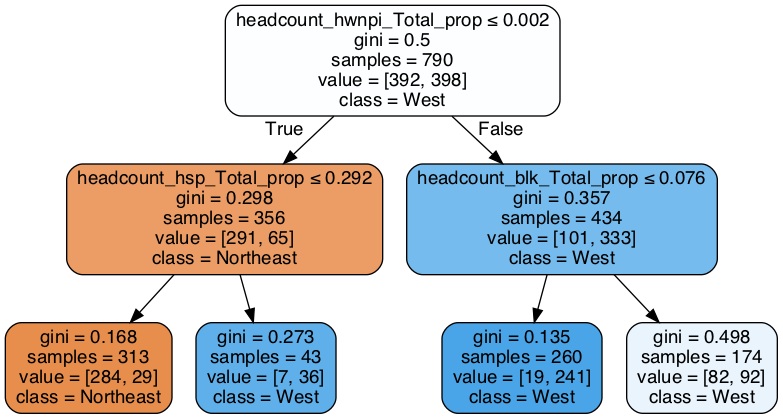

In [273]:
# Create DOT data
dot_data = export_graphviz(dtree, out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## Tune Max_Depth

[0.768209794397498, 0.7716536917515027, 0.8326651806507419, 0.8478278106771352, 0.8628882771087009, 0.8788335606715905, 0.8761240767848826, 0.8814806651584715, 0.870884068578526]


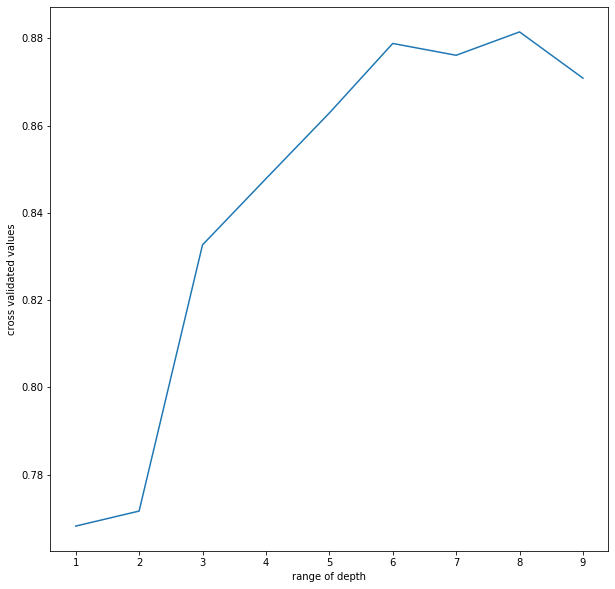

In [274]:
from sklearn.model_selection import cross_val_score
score = cross_val_score(dtree, X, y, cv = 10)
score.mean()
depth_range = range(1,10)
val = []
for depth in depth_range:
    ctree = DecisionTreeClassifier(max_depth = depth, random_state = 42)
    depth_score = cross_val_score(ctree, X, y, cv = 10)
    val.append(depth_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(depth_range, val)
plt.xlabel('range of depth')
plt.ylabel('cross validated values')
plt.show()

In [275]:
dtree_max_depth = pd.DataFrame(zip(depth_range, val))
dtree_max_depth.columns = ['max_depth', 'mean_score']
dtree_max_depth.sort_values(by = 'mean_score', ascending = False).head()

,max_depth,mean_score
7,8,0.881481
5,6,0.878834
6,7,0.876124
8,9,0.870884
4,5,0.862888


## Decision Tree (max_depth = 8) (F1 = 0.88)

In [297]:
dtree8 = DecisionTreeClassifier(max_depth = 8, random_state = 42)
dtree8.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='gini', max_depth=8,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [298]:
dtree8_y_pred = dtree8.predict(X_test)

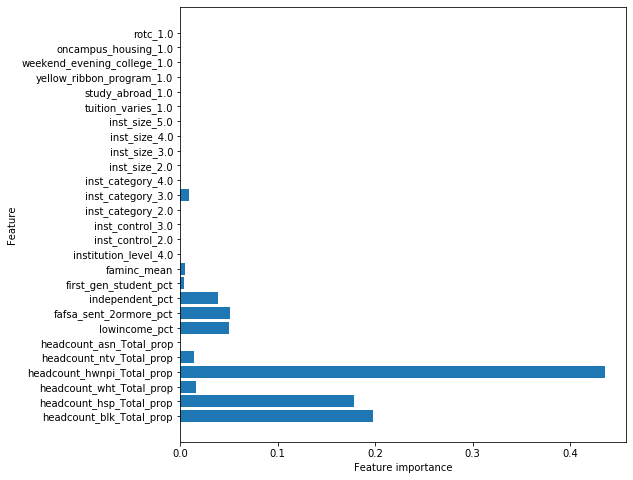

In [299]:
plot_feature_importances(dtree8.fit(X_train, y_train))

In [300]:
print(accuracy_score(y_test, dtree8_y_pred))
print(f1_score(y_test, dtree8_y_pred, average='weighted'))

0.8761061946902655
0.8760500520707373


Confusion Matrix, without normalization
[[155  19]
 [ 23 142]]


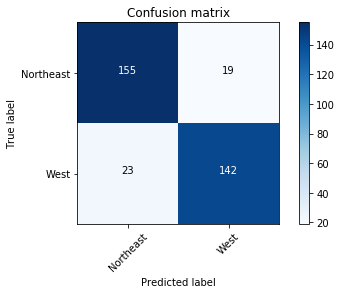

In [301]:
cm_tree = confusion_matrix(y_test, dtree8_y_pred)
plot_confusion_matrix(cm_tree, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [302]:
print(classification_report(y_test, dtree8_y_pred))

              precision    recall  f1-score   support

   Northeast       0.87      0.89      0.88       174
        West       0.88      0.86      0.87       165

    accuracy                           0.88       339
   macro avg       0.88      0.88      0.88       339
weighted avg       0.88      0.88      0.88       339



In [330]:
# Accuracy of training and test sets
test_accuracy = accuracy_score(y_test, dtree8_y_pred)

print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Validation accuracy: 87.61%


## Tune Model Using GridSearchCV

In [282]:
clf = DecisionTreeClassifier(random_state = 42)

param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 6, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20], 
    
}

gs_tree = GridSearchCV(clf, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

{'criterion': 'entropy', 'max_depth': 10, 'min_samples_split': 2}

## Decision Tree (max_depth = 10, min_samples_split = 2) (F1 = 0.88)

In [283]:
dtree_opt = DecisionTreeClassifier(criterion = 'entropy', max_depth = 10, 
                                   min_samples_split = 2, random_state = 42)
dtree_opt.fit(X_train, y_train)

DecisionTreeClassifier(class_weight=None, criterion='entropy', max_depth=10,
                       max_features=None, max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, presort=False,
                       random_state=42, splitter='best')

In [284]:
dtree_opt_y_pred = dtree_opt.predict(X_test)

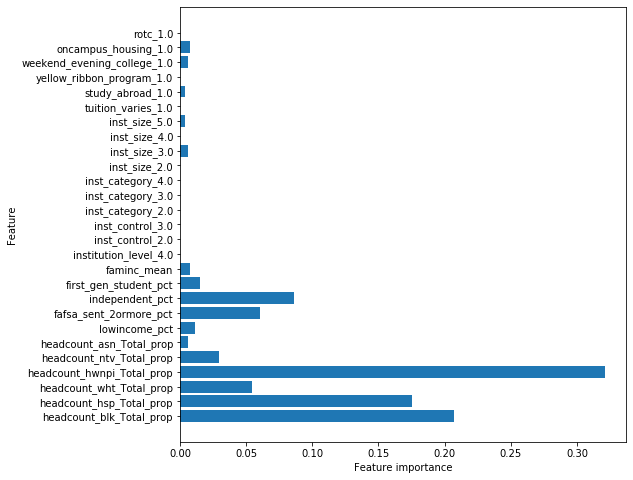

In [285]:
plot_feature_importances(dtree_opt.fit(X_train, y_train))

In [286]:
print(accuracy_score(y_test, dtree_opt_y_pred))
print(f1_score(y_test, dtree_opt_y_pred, average='weighted'))

0.8761061946902655
0.8760089773289115


Confusion Matrix, without normalization
[[156  18]
 [ 24 141]]


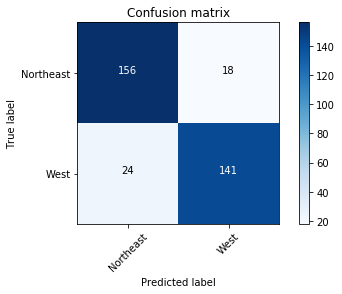

In [287]:
cm_tree = confusion_matrix(y_test, dtree_opt_y_pred)
plot_confusion_matrix(cm_tree, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [288]:
print(classification_report(y_test, dtree_opt_y_pred))

              precision    recall  f1-score   support

   Northeast       0.87      0.90      0.88       174
        West       0.89      0.85      0.87       165

    accuracy                           0.88       339
   macro avg       0.88      0.88      0.88       339
weighted avg       0.88      0.88      0.88       339



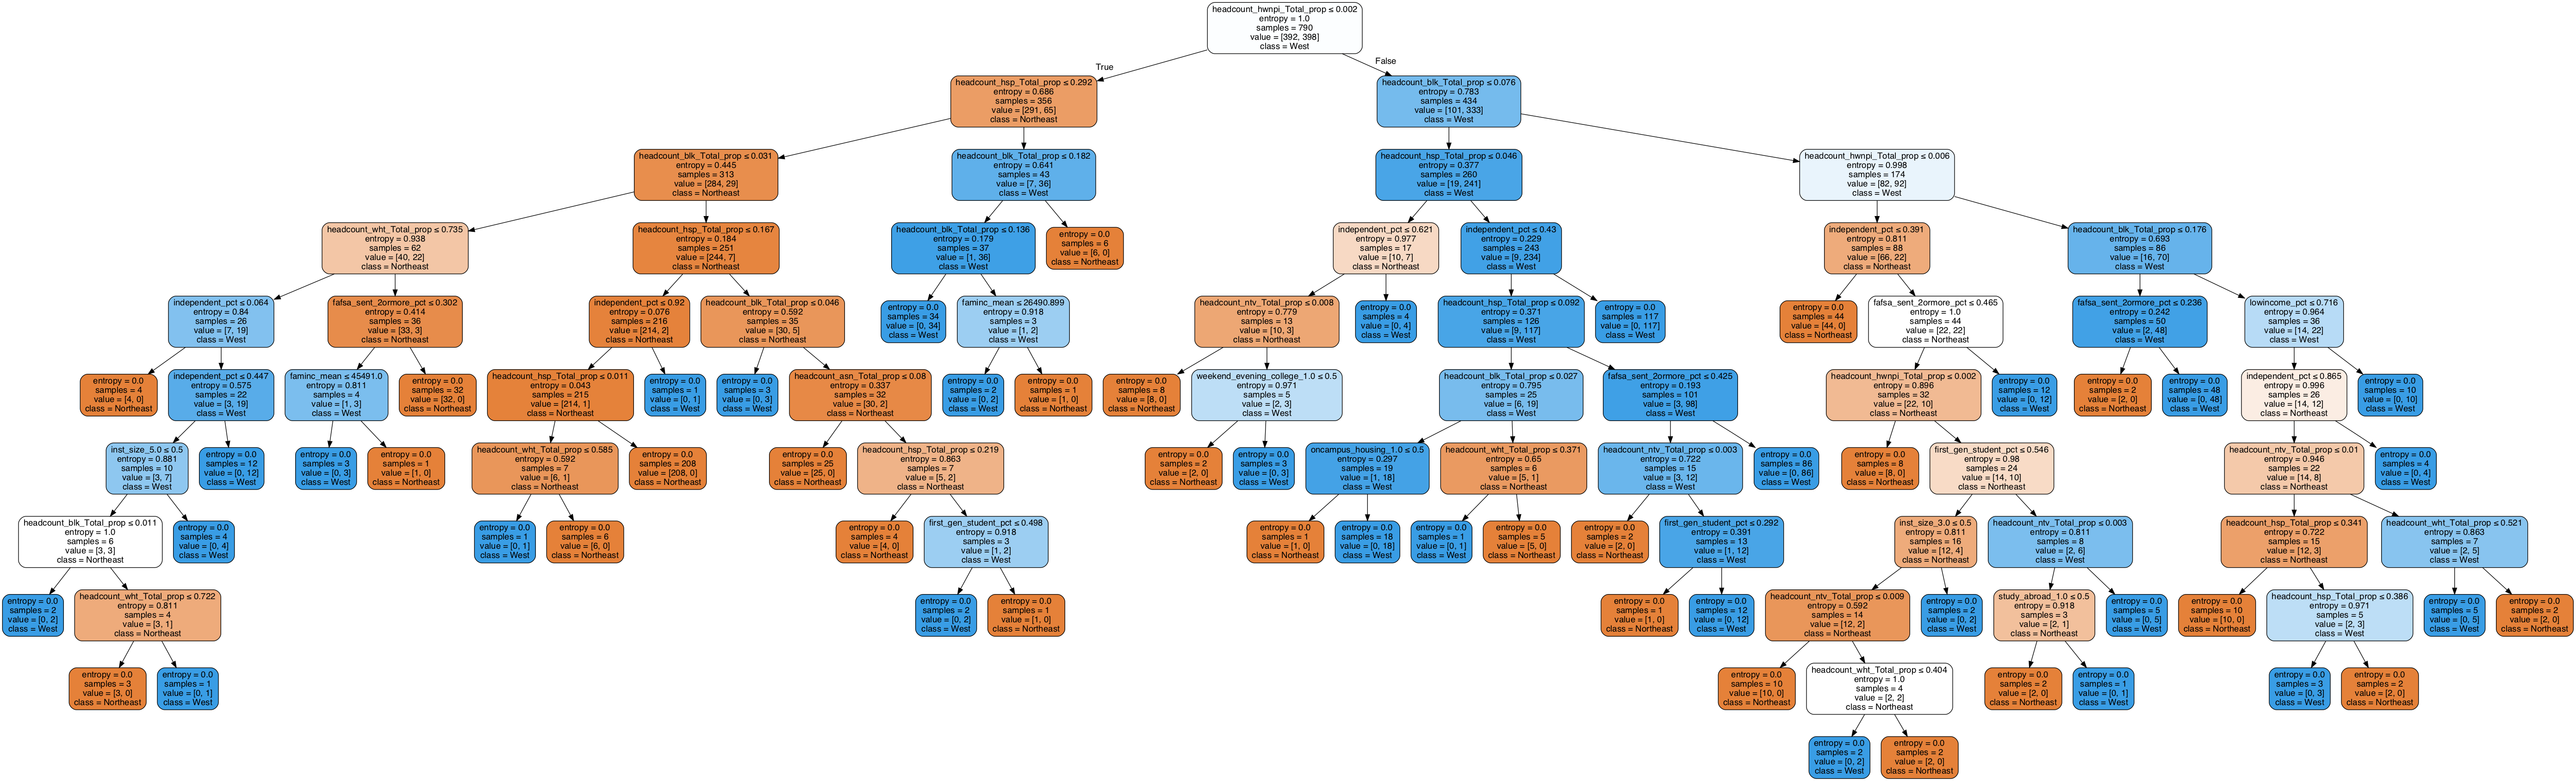

In [289]:
# Create DOT data
dot_data = export_graphviz(dtree_opt, out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [332]:
# Accuracy of training and test sets
test_accuracy = accuracy_score(y_test, dtree_opt_y_pred)

print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Validation accuracy: 87.61%


# Random Forest (n_est = 100, max_depth = 2) (F1 = 0.82)

In [290]:
forest = RandomForestClassifier(n_estimators = 100, max_depth = 2, random_state = 42)
forest.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='gini',
                       max_depth=2, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=2,
                       min_weight_fraction_leaf=0.0, n_estimators=100,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [291]:
forest_pred = forest.predict(X_test)

Confusion Matrix, without normalization
[[132  42]
 [ 19 146]]


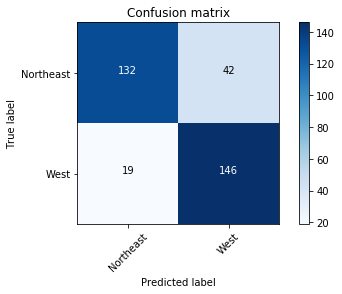

In [292]:
cm_forest = confusion_matrix(y_test, forest_pred)
plot_confusion_matrix(cm_forest, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [293]:
print(classification_report(y_test, forest_pred))

              precision    recall  f1-score   support

   Northeast       0.87      0.76      0.81       174
        West       0.78      0.88      0.83       165

    accuracy                           0.82       339
   macro avg       0.83      0.82      0.82       339
weighted avg       0.83      0.82      0.82       339



In [333]:
# Accuracy of training and test sets
test_accuracy = accuracy_score(y_test, forest_pred)

print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Validation accuracy: 82.01%


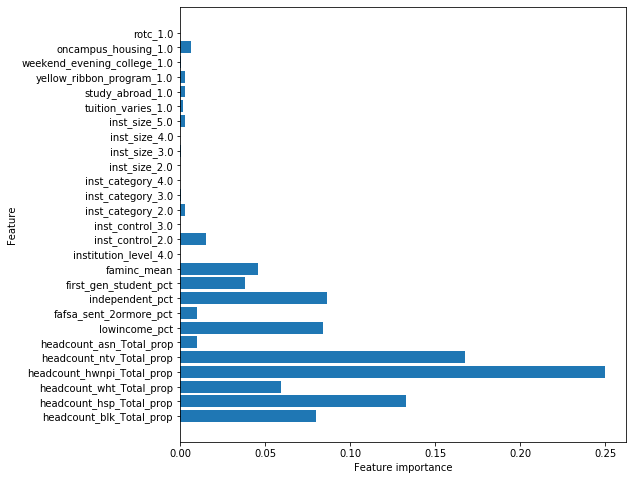

In [294]:
plot_feature_importances(forest.fit(X_train, y_train))

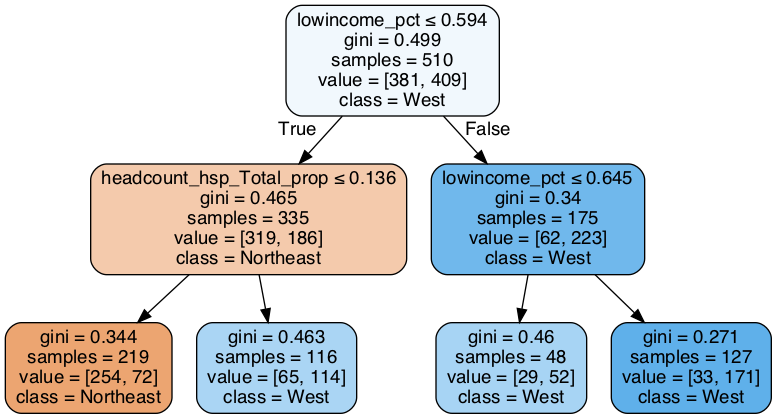

In [295]:
# Create DOT data
dot_data = export_graphviz(forest.estimators_[99], out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

## Optimize Random Forest Using GridSearchCV

In [303]:
forest = RandomForestClassifier(random_state = 42)

param_grid = {
    'n_estimators': [50, 100, 125, 150, 200],
    'criterion': ['gini', 'entropy'],
    'max_depth': [1, 2, 5, 8, 10],
    'min_samples_split': [2, 5, 10, 15, 20]
}

gs_tree = GridSearchCV(forest, param_grid, cv=3)
gs_tree.fit(X_train, y_train)

gs_tree.best_params_

{'criterion': 'entropy',
 'max_depth': 10,
 'min_samples_split': 5,
 'n_estimators': 125}

## Random Forest (n_estimators = 125, max_depth = 10, min_samples_split = 5) (F1 = 0.93)

In [304]:
forest_opt = RandomForestClassifier(criterion = 'entropy', n_estimators = 125, 
                                    max_depth = 10, min_samples_split = 5, 
                                    random_state = 42)
forest_opt.fit(X_train, y_train)

RandomForestClassifier(bootstrap=True, class_weight=None, criterion='entropy',
                       max_depth=10, max_features='auto', max_leaf_nodes=None,
                       min_impurity_decrease=0.0, min_impurity_split=None,
                       min_samples_leaf=1, min_samples_split=5,
                       min_weight_fraction_leaf=0.0, n_estimators=125,
                       n_jobs=None, oob_score=False, random_state=42, verbose=0,
                       warm_start=False)

In [305]:
forest_opt_y_pred = forest_opt.predict(X_test)

Confusion Matrix, without normalization
[[163  11]
 [ 13 152]]


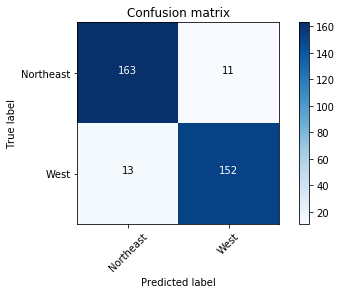

In [306]:
cm_forest_opt = confusion_matrix(y_test, forest_opt_y_pred)
plot_confusion_matrix(cm_forest_opt, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [307]:
print(classification_report(y_test, forest_opt_y_pred))

              precision    recall  f1-score   support

   Northeast       0.93      0.94      0.93       174
        West       0.93      0.92      0.93       165

    accuracy                           0.93       339
   macro avg       0.93      0.93      0.93       339
weighted avg       0.93      0.93      0.93       339



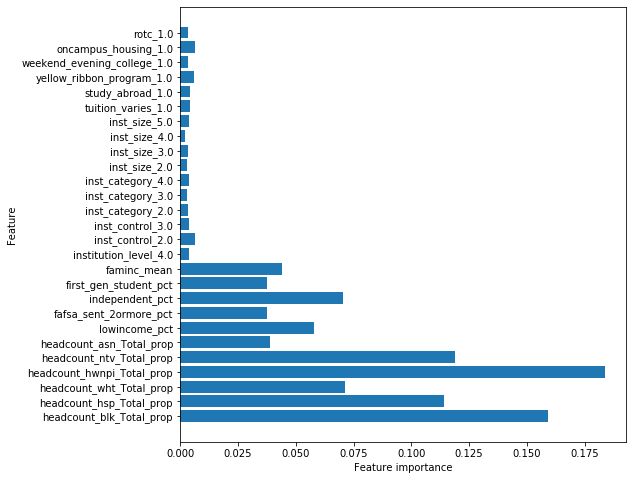

In [308]:
plot_feature_importances(forest_opt.fit(X_train, y_train))

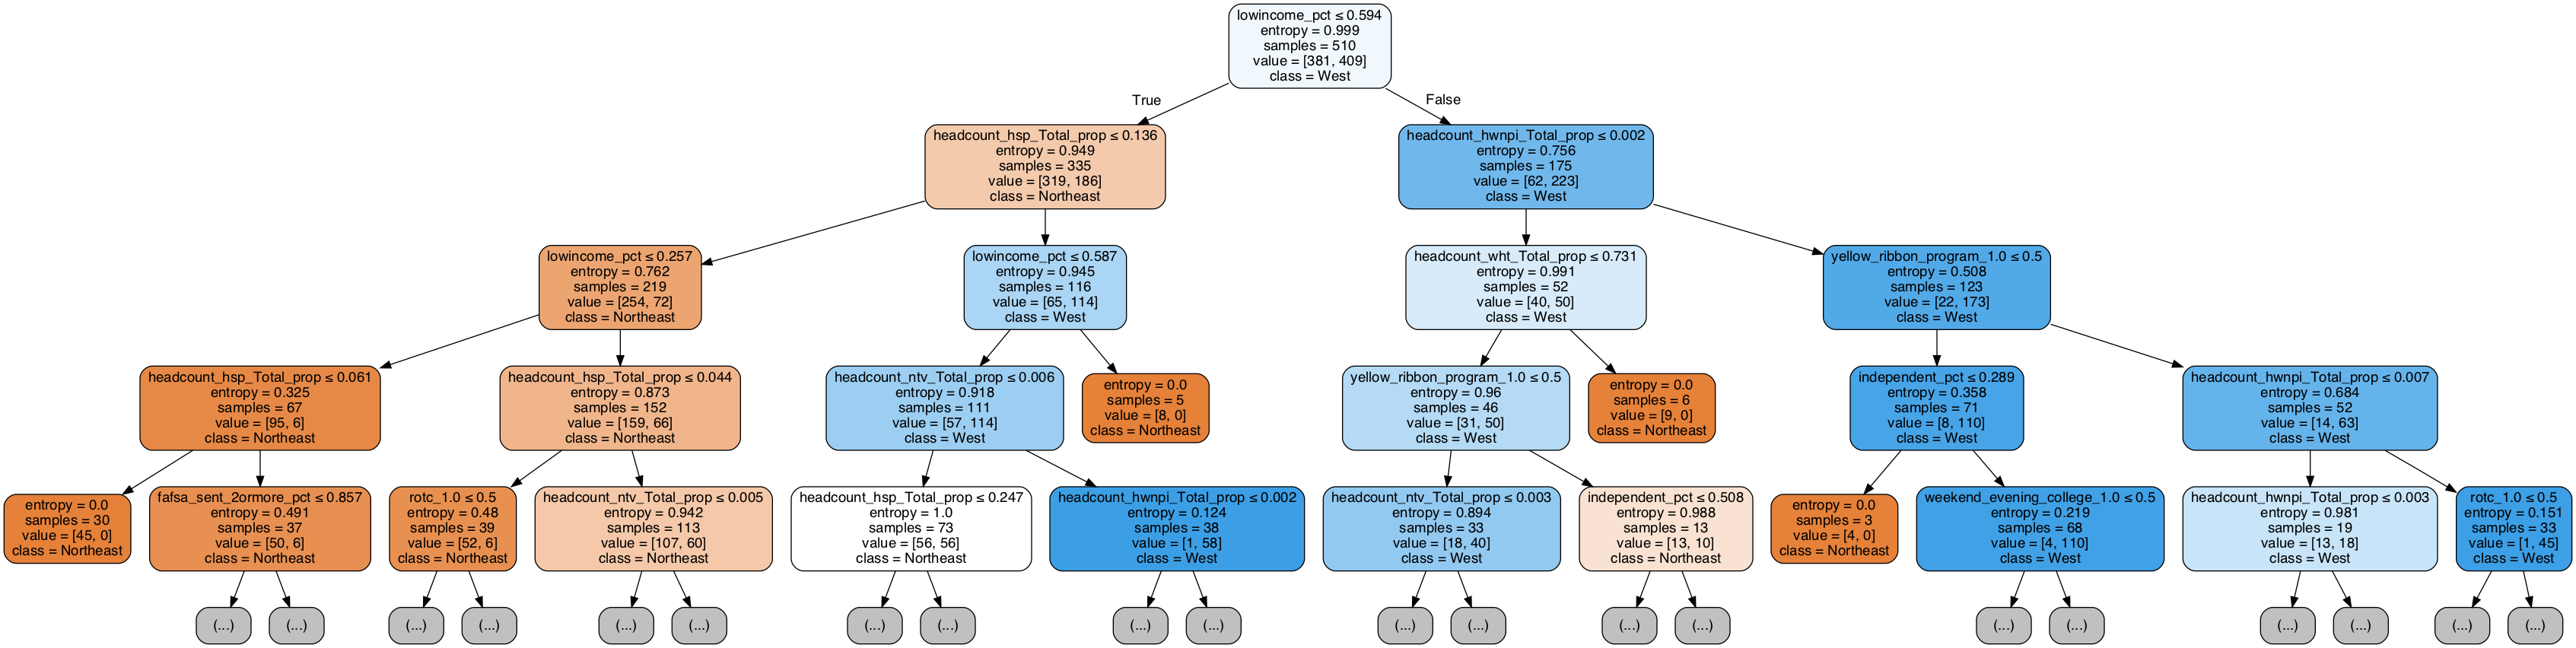

In [309]:
# Create DOT data
dot_data = export_graphviz(forest_opt.estimators_[99], out_file=None, 
                           feature_names=X_test.columns,  
                           class_names=np.unique(y).astype('str'), 
                           filled=True, rounded=True, special_characters=True, 
                           max_depth = 4)

# Draw graph
graph = graph_from_dot_data(dot_data)  

# Show graph
Image(graph.create_png())

In [334]:
# Accuracy of training and test sets
test_accuracy = accuracy_score(y_test, forest_opt_y_pred)

print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Validation accuracy: 92.92%


In [310]:
y_bin_train = y_train.replace({'Northeast': 0, 'West': 1})
y_bin_test = y_test.replace({'Northeast': 0, 'West': 1})

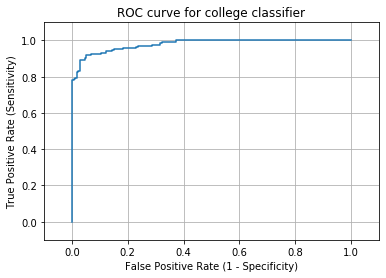

In [311]:
from sklearn.metrics import roc_curve, auc

# Scikit-learn's built in roc_curve method returns the fpr, tpr, and thresholds
# for various decision boundaries given the case member probabilites

# First calculate the probability scores of each of the datapoints:
y_score = forest_opt.fit(X_train, y_bin_train).predict_proba(X_test)[:, 1]

fpr, tpr, thresholds = roc_curve(y_bin_test, y_score)
plt.plot(fpr, tpr)
plt.xlim([-0.1, 1.1])
plt.ylim([-0.1, 1.1])
plt.title('ROC curve for college classifier')
plt.xlabel('False Positive Rate (1 - Specificity)')
plt.ylabel('True Positive Rate (Sensitivity)')
plt.grid(True)

# AdaBoost (n_estimators = 100) (F1 = 0.91)

In [312]:
ab_clf = AdaBoostClassifier(n_estimators = 100, random_state = 42)

In [313]:
ab_clf.fit(X_train, y_train)
ab_test_preds = ab_clf.predict(X_test)

Confusion Matrix, without normalization
[[161  13]
 [ 17 148]]


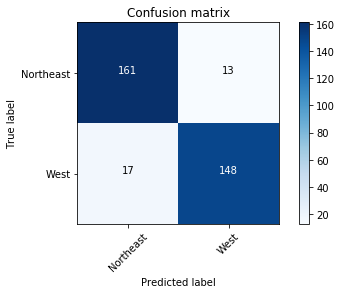

In [314]:
cm_ab = confusion_matrix(y_test, ab_test_preds)
plot_confusion_matrix(cm_ab, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [315]:
print(classification_report(y_test, ab_test_preds))

              precision    recall  f1-score   support

   Northeast       0.90      0.93      0.91       174
        West       0.92      0.90      0.91       165

    accuracy                           0.91       339
   macro avg       0.91      0.91      0.91       339
weighted avg       0.91      0.91      0.91       339



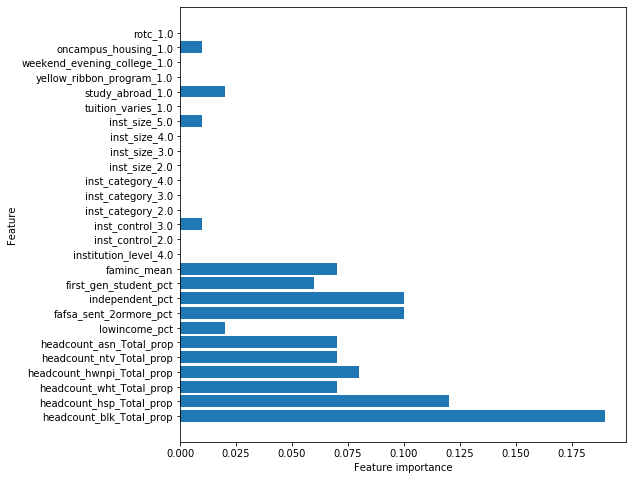

In [316]:
plot_feature_importances(ab_clf.fit(X_train, y_train))

## Optimize AdaBoost for n_estimators

[0.9000425566127708, 0.9159724532570364, 0.9133095459888659, 0.9151110630558698, 0.9142337314525252, 0.9159879787965488, 0.9133410129305567]


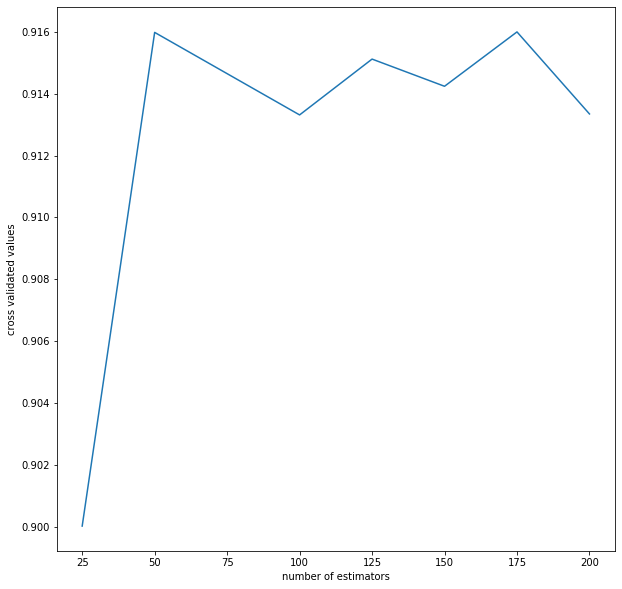

In [317]:
n_est = [25, 50, 100, 125, 150, 175, 200]
val = []
for n in n_est:
    ab_clf = AdaBoostClassifier(n_estimators = n, random_state = 42)
    n_score = cross_val_score(ab_clf, X, y, cv = 10)
    val.append(n_score.mean())
print(val)
plt.figure(figsize = (10,10))
plt.plot(n_est, val)
plt.xlabel('number of estimators')
plt.ylabel('cross validated values')
plt.show()

## AdaBoost (n_estimators = 175) (F1 = 0.91)

In [318]:
ab_clf_opt = AdaBoostClassifier(n_estimators = 175, random_state = 42)

In [319]:
ab_clf_opt.fit(X_train, y_train)
ab_test_preds_opt = ab_clf_opt.predict(X_test)

Confusion Matrix, without normalization
[[159  15]
 [ 16 149]]


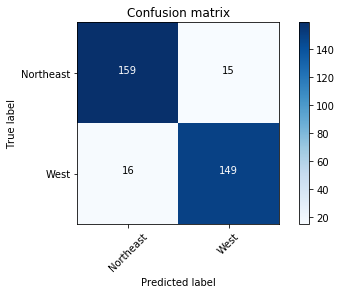

In [320]:
cm_ab_opt = confusion_matrix(y_test, ab_test_preds_opt)
plot_confusion_matrix(cm_ab_opt, regions,
                          normalize=False,
                          title='Confusion matrix',
                          cmap=plt.cm.Blues)

In [321]:
print(classification_report(y_test, ab_test_preds_opt))

              precision    recall  f1-score   support

   Northeast       0.91      0.91      0.91       174
        West       0.91      0.90      0.91       165

    accuracy                           0.91       339
   macro avg       0.91      0.91      0.91       339
weighted avg       0.91      0.91      0.91       339



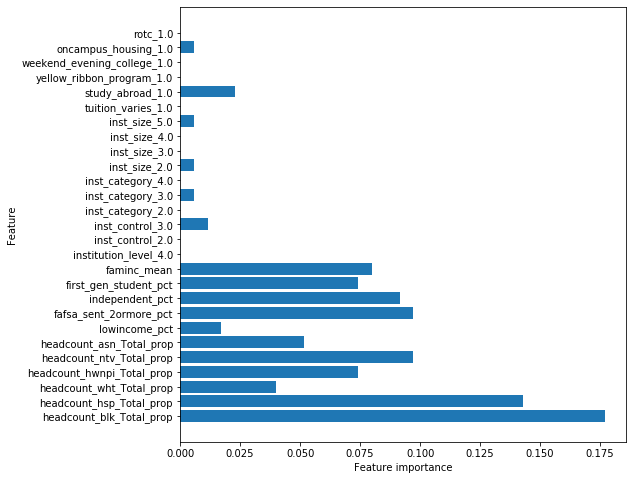

In [322]:
plot_feature_importances(ab_clf_opt.fit(X_train, y_train))

# XGBoost

In [323]:
# Instantiate XGBClassifier
xgb = XGBClassifier(random_state = 42)

# Fit XGBClassifier
xgb.fit(X_train, y_train)

# Predict on training and test sets
training_preds = xgb.predict(X_train)
test_preds = xgb.predict(X_test)

# Accuracy of training and test sets
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

Training Accuracy: 99.87%
Validation accuracy: 91.74%


In [324]:
param_grid = {
    'learning_rate': [0.1, 0.2],
    'max_depth': [6, 8],
    'min_child_weight': [1],
    'subsample': [0.5],
    'n_estimators': [100, 125],
}

In [325]:
grid_clf = GridSearchCV(xgb, param_grid, scoring='accuracy', cv=None, n_jobs=1)
grid_clf.fit(X_train, y_train)

best_parameters = grid_clf.best_params_

print('Grid Search found the following optimal parameters: ')
for param_name in sorted(best_parameters.keys()):
    print('%s: %r' % (param_name, best_parameters[param_name]))

training_preds = grid_clf.predict(X_train)
test_preds = grid_clf.predict(X_test)
training_accuracy = accuracy_score(y_train, training_preds)
test_accuracy = accuracy_score(y_test, test_preds)

print('')
print('Training Accuracy: {:.4}%'.format(training_accuracy * 100))
print('Validation accuracy: {:.4}%'.format(test_accuracy * 100))

//anaconda3/lib/python3.7/site-packages/sklearn/model_selection/_split.py:1978: FutureWarning: The default value of cv will change from 3 to 5 in version 0.22. Specify it explicitly to silence this warning.
  warnings.warn(CV_WARNING, FutureWarning)


Grid Search found the following optimal parameters: 
learning_rate: 0.1
max_depth: 6
min_child_weight: 1
n_estimators: 100
subsample: 0.5

Training Accuracy: 99.75%
Validation accuracy: 92.33%
